# Nonadiabatic Scattering Dynamics with Model Hamiltonians

## Table of content <a name="TOC"></a>

1. [Recipes](#1)  

      
2. [TSH calculations](#2)  

  2.1. [Setting up the NBRA-based Hamiltonian](#2.1)
  
  2.2. [Setting up the model Hamiltonian](#2.2)
  
  2.3. [Setting up the calculations and methods](#2.3)
  
  2.4. [Running the calculations](#2.4)


3. [Detailed analysis of trajectories](#3)  

  3.1. [Plotting scripts](#3.1)
     
  3.2. [Plot them now](#3.2)
  
  
4. [Analysis of the scattering](#4)

  4.1. [Plotting and analysis functions](#4.1)
  
  4.2. [Run calculations and plot the results](#4.2)
  

## A. Learning objectives

* to use pre-defined model Hamiltonians from Libra collection
* to set up the automated calculations for multiple possible methods withing the general TSH framework
* to analyze and visualize the results within the indivdual simulations
* to analyze and visualize the results across multiple simulations (scattering)


## B. Use cases

* [Setting up the NBRA Hamiltonians](#setting_nbra_hamiltonian)
* [Creating HDF5 files](#creating_hdf5)
* [Reading HDF5 files](#reading_hdf5)

## C. Functions

- `libra_py`
  - `data_read`
    - [`get_data_from_file2`](#get_data_from_file2)
  - `models`
    - `Tully`
      - [`Tully1`](#Tully1)
      - [`Tully2`](#Tully2)
      - [`Tully3`](#Tully3)
    - `Zhu`
      - [`dual_RZD`](#dual_RZD)
  - `workflows`
    - `nbra`
      - `step4`
        - [`namd_workflow`](#namd_workflow)
                  

## D. Classes and class members
 
  None

Import Libra and other dependencies such as numpy and matplotlib

Note these lines:

    mpl.use('TkAgg')    # to be able to show figures
    %matplotlib inline  # to keep figures inside the notebook, not detached
    
By default, matplotlib uses the "Agg" backend, which doesn't work with the `show` function, so you can't visualize figures in the Jupyter notebook, only save them as standalone figures with `savefig`. To enable such a visualization, we need to redefine the default backend and request to use `TkAgg` instead.

However, by default, the `TkAgg` will show figures in separate windows and will stop the Python workflow execution until you close those windows. For this reason we also need the second line `%matplotlib inline`

**Update**: The above instructions aren't necessary, if we don't have any comments in the `%matplotlib inline` line 

In [19]:
import os
import sys
import math
import cmath
import time


import h5py
import multiprocessing as mp
import numpy as np

# Uncomment for the scripts 
#import matplotlib as mpl
#mpl.use('TkAgg')    # to be able to show figures
%matplotlib inline  
import matplotlib.pyplot as plt

# to keep figures inside the notebook, not detached


from liblibra_core import *
import util.libutil as comn

from libra_py import units as units
from libra_py import data_conv, data_stat, data_outs, data_read, data_savers
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.workflows.nbra.step4 as step4
import libra_py.models.Tully as Tully
import libra_py.models.Holstein as Holstein
import libra_py.models.Esch_Levine as EL
import libra_py.models.Zhu as Zhu
import libra_py.dynamics.tsh.compute as tsh



## 1. Recipes <a name="1"></a>
[Back to TOC](#TOC)

The block below is also implemented in `recipes.py` file supplied with this tutorial. One would need to import it as a module in other scripts.

The `recipes` module implements a number of recipes that can be used in TSH calculations. Each recipe could be regarded as a separate method. These methods are defined as a combinations of 4 main options:

* how to compute the hop proposal probability

* how to compute the hop acceptance probability

* how to rescale velocity at frustrated or accepted hops

* how to incorporate decoherence effects


Functions' description:

* `set_recipe` - defines internal parameters to be used by Libra's dynamics module, depending of the selection of the options for the categories listed above. 

* `recipe_mapping` - maps the set of 4 integers (selectiong options in 4 categories) to a single integer which is the global index of the selected recipe in the whole set of possibilities.  **NOTE: needs to be changed if more options are added to `set_recipe`**

* `recipe_inv_mapping` - is the inverse of `recipe_mapping` **NOTE: needs to be changed if more options are added to `set_recipe`**

* `make_all_sets` - generates a list of 4-component lists, covering all possible combinations of options in `set_recipe` **NOTE: needs to be changed if more options are added to `set_recipe`**


In [24]:
def set_recipe(recipe):

    # Format for the `recipe` (int list)

    name = ""
    params = { "rep_ham":0 }                              # Hamiltonian is definied in the diabatic basis initially
    params.update( {"force_method":1, "rep_force":1} )    # state-specific forces, compute them in the adiabatic rep
    params.update( {"nac_update_method":1} )              # update NACs based on derivative couplings and momenta
    params.update( {"time_overlap_method":0} )            # state-tracking based on the on-the-fly time-overlaps                         


    # ======= Hop proposal algo ======
    if recipe[0] == 0:
        name = F"{name}_FSSH"
        params.update( {"tsh_method": 0} )                    # FSSH prop algo 


    # ======= Hop acceptance =========
    if recipe[1] == 0:
        name = F"{name}_E"
        params.update( {"hop_acceptance_algo":10} )           # acceptance on the adiabatic energy conservation
    elif recipe[1] == 1:
        name = F"{name}_D"
        params.update( {"hop_acceptance_algo":20} )           # acceptance on the ability to rescale along NAC
    elif recipe[1] == 2:
        name = F"{name}_F"
        params.update( {"hop_acceptance_algo":21} )           # acceptance on the ability to rescale along dF
    elif recipe[1] == 3:
        name = F"{name}_B"
        params.update( {"hop_acceptance_algo":31} )           # acceptance with Boltzmann probability


    # ======= Velocity rescaling =========
    if recipe[2] == 0:
        name = F"{name}_V+"
        params.update( {"momenta_rescaling_algo":100} )          # rescale along V, no reversal on frustr. hops
    elif recipe[2] == 1:
        name = F"{name}_V-"
        params.update( {"momenta_rescaling_algo":101} )          # rescale along V, reversal on frustr. hops
    elif recipe[2] == 2:
        name = F"{name}_D+"
        params.update( {"momenta_rescaling_algo":200} )          # rescale along D, no reversal on frustr. hops
    elif recipe[2] == 3:
        name = F"{name}_D-"
        params.update( {"momenta_rescaling_algo":201} )          # rescale along D, reversal on frustr. hops
    elif recipe[2] == 4:
        name = F"{name}_F+"
        params.update( {"momenta_rescaling_algo":210} )          # rescale along dF, no reversal on frustr. hops
    elif recipe[2] == 5:
        name = F"{name}_F-"
        params.update( {"momenta_rescaling_algo":211} )          # rescale along dF, reversal on frustr. hops


    # ======= Decoherence options =========
    if recipe[3] == 0:
        name = F"{name}_no_decoh"
        params.update( {"decoherence_algo":-1 } )             # no decoherence
        params.update( {"decoherence_times_type":-1 } )       # no need for dephasing times
        params.update( {"dephasing_informed":0 } )            # no deph-informed

    elif recipe[3] == 1:
        name = F"{name}_IDA"
        params.update( {"decoherence_algo":1 } )              # IDA
        params.update( {"decoherence_times_type":-1 } )       # no need for dephasing times
        params.update( {"dephasing_informed":0 } )            # no deph-informed - doesn't matter

    elif recipe[3] == 2:
        name = F"{name}_mSDM_user_tau"
        params.update( {"decoherence_algo":0 } )              # mSDM
        params.update( {"decoherence_times_type":0 } )        # provided by user
        params.update( {"dephasing_informed":0 } )            # no deph-informed

    elif recipe[3] == 3:
        name = F"{name}_mSDM_user_tau_deph-inf"
        params.update( {"decoherence_algo":0 } )              # mSDM
        params.update( {"decoherence_times_type":0 } )        # provided by user
        params.update( {"dephasing_informed":1 } )            # deph-informed

    elif recipe[3] == 4:
        name = F"{name}_mSDM_EDC"
        params.update( {"decoherence_algo":0 } )              # mSDM
        params.update( {"decoherence_times_type":0 } )        # EDC
        params.update( {"dephasing_informed":0 } )            # no deph-informed

    elif recipe[3] == 5:
        name = F"{name}_mSDM_EDC_deph-inf"
        params.update( {"decoherence_algo":0 } )              # mSDM
        params.update( {"decoherence_times_type":0 } )        # EDC
        params.update( {"dephasing_informed":1 } )            # deph-informed
     
    elif recipe[3] == 6:
        name = F"{name}_mSDM_Schwartz"
        params.update( {"decoherence_algo":0 } )              # mSDM
        params.update( {"decoherence_times_type":3 } )        # Schwartz
        params.update( {"dephasing_informed":0 } )            # no deph-informed

    elif recipe[3] == 7:
        name = F"{name}_mSDM_Schwartz_deph-inf"
        params.update( {"decoherence_algo":0 } )              # mSDM
        params.update( {"decoherence_times_type":3 } )        # Schwartz
        params.update( {"dephasing_informed":1 } )            # deph-informed

    elif recipe[3] == 8:
        name = F"{name}_BC"
        params.update( {"decoherence_algo":3 } )              # Branching-corrected FSSH
        params.update( {"decoherence_times_type":-1 } )       # no need for dephasing times
        params.update( {"dephasing_informed":0 } )            # no deph-informed, doesn't matter

    elif recipe[3] == 9:
        name = F"{name}_AFSSH"
        params.update( {"decoherence_algo":2 } )              # Aumented FSSH
        params.update( {"decoherence_times_type":-1 } )       # no need for dephasing times
        params.update( {"dephasing_informed":0 } )            # no deph-informed, doesn't matter



    return name, params

def recipe_mapping(recipe):
    # mapping: [a, b, c, d] -> a * 240 + b * 60 + c * 10 + d
    # Normal FSSH: a = 0, b = 1, c = 3, d = 0   => indx = 0*240 + 1*60 + 3*10+ 0 = 90

    a, b, c, d = recipe[0], recipe[1], recipe[2], recipe[3]

    indx = 240*a + 60*b + 10*c + d

    return indx



def recipe_inv_mapping(indx):
    # mapping: [a, b, c, d] -> a * 240 + b * 60 + c * 10 + d

    r1 = indx % 240  # 60*b + 10*c + d
    r2 = r1 % 60     # 10*c + d
    d = r2 % 10
    c = (r2 - d)/10
    b = (r1 - r2)/60
    a = (indx - r1)/240
    
    return [a,b,c,d]
     

def make_all_sets():

    # ============== So far, 240 methods ============
    # mapping: [a, b, c, d] -> a * 240 + b * 60 + c * 10 + d
    # Normal FSSH: a = 0, b = 1, c = 3, d = 0   => indx = 0*240 + 1*60 + 3*10+ 0 = 90

    all_sets = []
    for a in [0]:
        for b in [0, 1, 2, 3]:
            for c in [0, 1, 2, 3, 4, 5]:
                for d in range(0, 10):
                    all_sets.append([a, b, c, d]) 

    return all_sets



## 2. TSH calculations <a name="2"></a>
[Back to TOC](#TOC)

The code blocks of this section are summarized in `run_namd_2state_models.py`, but are explained here in a bit more detail

### 2.1. Setting up the NBRA-based Hamiltonian<a name="2.1"></a>
[Back to TOC](#TOC)


These functions are for the NBRA calculations.

* `get_all` - reads the vibronic Hamiltonian and time-overlap matrices for all times of simulation, in the format of Libra output (1 line per timestep) and generates lists of matrices containing adiabatic energies (Hadi, diagonal), vibronic Hamiltonians (Hvib, same info as the input in the hvib_adi.txt file), NACs (nac, excluding the i * hbar factor), and time-overlaps (St, same info as the input in the St.txt file). Note that to generate such files in the prior Libra runs, one needs to run the dynamics calculations with the `verbosity_level = 4`

* `compute_model_nbra_files` - this function imitates the calculation of the needed properties (Hadi, Hvib, NAC, St) at every timestep by pulling the corresponding matrix from the lists of such matrices passed as the elements of the `params` dictionary. Such lists of matrices can be generated by the `get_all` function

<a name="get_data_from_file2"></a><a name="setting_nbra_hamiltonian"></a>

In [5]:
def get_all(nstates, prefix):

    Hadi, Hvib, nac, St = [], [], [], []
    dummy = MATRIX(nstates, nstates)

 
    tmp = data_read.get_data_from_file2(F"{prefix}/hvib_adi.txt", list(range(2*nstates*nstates)) )
    tmp2 = data_read.get_data_from_file2(F"{prefix}/St.txt", list(range(2*nstates*nstates)) )
    nsteps = len(tmp[0])

    for step in range(nsteps):
        # Hvib
        hvib = CMATRIX(nstates, nstates)
        for i in range(nstates):
            for j in range(nstates):
                re = tmp[2*(i*nstates+j) + 0][step]
                im = tmp[2*(i*nstates+j) + 1][step]
                hvib.set(i, j, re+1j*im)
        Hvib.append(hvib)

        # Hadi
        Hadi.append( CMATRIX(hvib.real(), dummy) )

        # NAC
        nac.append( CMATRIX(-1.0*hvib.imag(), dummy) )

        # St
        st = CMATRIX(nstates, nstates)
        for i in range(nstates):
            for j in range(nstates):
                re = tmp2[2*(i*nstates+j) + 0][step]
                im = tmp2[2*(i*nstates+j) + 1][step]
                st.set(i, j, re+1j*im)
        St.append(st)

    return Hadi, Hvib, nac, St


class tmp:
    pass

def compute_model_nbra_files(q, params, full_id):
    """   
    Read in the vibronic Hamiltonians along the trajectories    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof, but they do not really affect anything
        params ( dictionary ): model parameters

            * **params["timestep"]** ( int ):  [ index of the file to read ]
            * **params["prefix"]**   ( string ):  [ the directory where the hdf5 file is located ]
            * **params["filename"]** ( string ):  [ the name of the HDF5 file ]
        
    Returns:       
        PyObject: obj, with the members:

            * obj.hvib_adi ( CMATRIX(n,n) ): adiabatic vibronic Hamiltonian 
            
    """
                                    
    timestep = params["timestep"]
    
    #=========== Basis transform, if available =====
    basis_transform = CMATRIX(2, 2)            
    basis_transform.identity()        
                                                
    #========= Time-overlap matrices ===================
    #time_overlap_adi = CMATRIX(2, 2)            
    #time_overlap_adi.identity()    
        
    obj = tmp()
    obj.ham_adi = params["HADI"][timestep]
    obj.nac_adi = params["NAC"][timestep]
    obj.hvib_adi = params["HVIB"][timestep]
    obj.basis_transform = basis_transform
    obj.time_overlap_adi = params["ST"][timestep]
            
    return obj

### 2.2. Setting up the model Hamiltonian<a name="2.2"></a>
[Back to TOC](#TOC)


`compute_model` - is a analytic model-based Hamiltonians, similar to what `compute_model_nbra_files` but all calculations are conducted explicitly although only in the diabatic basis.  

In this example, we can choose from one of 3 Tully models or Zhu's duar RZD model. More models can be added by analogy.

<a name="Tully1"></a><a name="Tully2"></a><a name="Tully3"></a><a name="dual_RZD"></a>

In [6]:
def compute_model(q, params, full_id):


    #model_params = {"nstates":2, "filename":None, "istep":0, "E_n":[0.0,  -0.001], "x_n":[0.0, 4.0], 
    #                "k_n":[0.002, 0.004], "V": [ [0.0, 0.001],  [0.001, 0.0] ],
    #                "alpha": [ [0.00, 0.00], [0.00, 0.00] ],  "x_nm": [ [0.00, 0.00], [0.00, 0.00] ] ,
    #                "w0":0.25, "w1":0.25, "eps":0.0, "i_crit":0, "delta":0.0
    #               }

    #model_params = { } #"nstates":2, "filename":None, "istep":0 }

    #model_params.update({"model":1, "V":0.00})    # LZ type


    model = params["model"]
    res = None    

    if model==1:        
        res = Tully.Tully1(q, params, full_id)
        #res = EL.JCP_2020(q, params, full_id)
    elif model==2:
        res = Tully.Tully2(q, params, full_id)
        #res = Holstein.Holstein5(q, params, full_id)
    elif model==3:
        res = Tully.Tully3(q, params, full_id)
        #res = compute_model_nbra_files(q, params, full_id)
    elif model==4:
        res = Zhu.dual_RZD(q, params, full_id)

    return res



### 2.3. Setting up the calculations and methods<a name="2.3"></a>
[Back to TOC](#TOC)


This block is what makes this tutorial specific, but it can be adapted for other problems and simulation types. 

Here, we set up the calculations with:

* 2 states
* 2 threads
* starting on the lower state
* 2000 steps
* 25 trajectoris
* starting at -15 with the initial momentum given in the input

and other system- and simulation-specific parameters

What is very important is that we call the `step4.namd_workflow` function with

    ham_rep, is_nbra = 0, -1  # free-format

The `is_nbra = -1` choice enables the function to accept the `dyn_params` as they are, without internally re-defining some of the parameters to select the method. This goes together with setting `methods = [-1]` instead of selecting one of the pre-defined methods. 

Note the instuction 

    dyn_params.update( recipe )   # recipe parameters
    
It takes one of the recipe setups and updates the `dyn_params` veriable accordingly. 

This is good place to also revise what `rep_ham`, `is_nbra`, and `method` parameters of the `namd_workflow` are doing:


* `ham_rep` sets:  rep_ham   
    
* `is_nbra` sets:  force_method, rep_force, 
                      nac_update_method, time_overlap_method, 
                      hop_acceptance_algo, and momenta_rescaling_algo
     
* `method` (from methods) sets: tsh_method, decoherence_algo, dephasing_informed 
 
 
Choose the following setups:

* `ham_rep, is_nbra = 0, -1` is a free setup for `is_nbra` and `method` parameters
* `ham_rep, is_nbra = 0, 0` is for non-NBRA
* `ham_rep, is_nbra = 1, 1`  is for file-based NBRA
* `ham_rep, is_nbra = 0, 2`  is for on-the-fly NBRA

<a name="namd_workflow"></a>

In [10]:
def main_tully_mdls(model_indx, p0, recipe_indx, recipes_pool ):
    """
    Tully models

    """
    
    nthreads = 2
    batches = list(range(2))

    recipe_name, recipe = set_recipe( recipes_pool[recipe_indx] )

    methods_map = { -1 : recipe_name }  # recipe name
    init_states = [0]
    methods = [-1]

    #================== SET UP THE DYNAMICS AND DISTRIBUTED COMPUTING SCHEME  ===============                      

    rnd = Random()   
    SCH_alp = MATRIX(1, 1);  SCH_alp.set(0,0, 1.0)
    decoherence_rates = MATRIX(2,2)
    tau = 1.0/100.0  # a.u.^-1
    decoherence_rates.set(0, 1, tau)
    decoherence_rates.set(1, 0, tau)

    ave_gaps = MATRIX(2,2)
    ave_gaps.set(1,1)
   
    # Common prms
    dyn_params = { "nsteps":2000, "dt":(1.0/p0)*units.fs2au, 
                   "ntraj":25, "x0":[-15.0], "p0":[p0], "masses":[2000.0], "k":[(0.000025/2000.0) * p0**4], 
                   "nstates":2, "istate":[1, 0],
                   "which_adi_states":range(2), "which_dia_states":range(2),
                   "time_overlap_method":1, "mem_output_level":-1,  "txt_output_level":3,
                   "properties_to_save": ['timestep', 'time', 'q', 'states', 'Ekin_ave', 'Epot_ave', 
                                          'Etot_ave', 'SH_pop', 'SH_pop_raw', 'p', 'Cadi' ],
                   "state_tracking_algo":2, "convergence":0,  "max_number_attempts":1000, "min_probability_reordering":0.01,
                   "do_phase_correction":1, "Temperature": 300.0,   
                   "schwartz_decoherence_inv_alpha":SCH_alp,
                   "decoherence_rates":decoherence_rates,
                   "ave_gaps":ave_gaps,
                   "num_electronic_substeps":1,
                   "sdm_norm_tolerance":0.001,
                   "is_nbra":0
                 }
 
    # Method-defining params
    dyn_params.update( recipe )   # recipe parameters
    print(dyn_params)

    model_params = {"model":model_indx}
    # `ham_rep` sets:  rep_ham   
    # `is_nbra` sets:  force_method, rep_force, 
    #                  nac_update_method, time_overlap_method, 
    #                  hop_acceptance_algo, and momenta_rescaling_algo
    # `method` (from methods) sets: tsh_method, decoherence_algo, dephasing_informed 
    # 
    #  `-1` is a free setup for `is_nbra` and `method` parameters
    #
    ham_rep, is_nbra = 0, -1  # free-format
    #ham_rep, is_nbra = 0, 0  # non-NBRA
    #ham_rep, is_nbra = 1, 1 # file-based NBRA
    #ham_rep, is_nbra = 0, 2 # on-the-fly NBRA


    os.system(F"mkdir MDL_{model_indx}_P0_{p0}_RECIPE_{recipe_indx}")
    dyn_params.update({ "dir_prefix":F"MDL_{model_indx}_P0_{p0}_RECIPE_{recipe_indx}" })
    step4.namd_workflow(dyn_params, compute_model, model_params, rnd, nthreads, 
                        methods_map, init_states, methods, batches, "fork", True, ham_rep, is_nbra)



### 2.4. Running the calculations<a name="2.4"></a>
[Back to TOC](#TOC)

Now it is time to run the calculations.

In this example we are only running the calculations for one of the models (4 = RZD), with several inital momenta, and only with the `fssh_plus` recipe.

See the commented lines if you want to run a whole bunch of calculations.

In [11]:

all_sets = make_all_sets()

fssh = recipe_mapping([0, 1, 3, 0])  
fssh_plus = recipe_mapping([0, 1, 2, 0])  

#for mdl in [1, 2, 3]:
for mdl in [4]:
    for p0 in np.arange(10.0, 40.0, 5.0):
        #for recipe_indx in all_sets:
        #for recipe_indx in [90]:
        for recipe_indx in [ fssh_plus ]:
            main_tully_mdls(mdl, p0, recipe_indx, all_sets)


{'nsteps': 2000, 'dt': 4.133939644481191, 'ntraj': 25, 'x0': [-15.0], 'p0': [10.0], 'masses': [2000.0], 'k': [0.000125], 'nstates': 2, 'istate': [1, 0], 'which_adi_states': range(0, 2), 'which_dia_states': range(0, 2), 'time_overlap_method': 0, 'mem_output_level': -1, 'txt_output_level': 3, 'properties_to_save': ['timestep', 'time', 'q', 'states', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'SH_pop', 'SH_pop_raw', 'p', 'Cadi'], 'state_tracking_algo': 2, 'convergence': 0, 'max_number_attempts': 1000, 'min_probability_reordering': 0.01, 'do_phase_correction': 1, 'Temperature': 300.0, 'schwartz_decoherence_inv_alpha': <liblibra_core.MATRIX object at 0x7f7c7c77d9d0>, 'decoherence_rates': <liblibra_core.MATRIX object at 0x7f7c1b3b9f80>, 'ave_gaps': <liblibra_core.MATRIX object at 0x7f7c1b3b9d18>, 'num_electronic_substeps': 1, 'sdm_norm_tolerance': 0.001, 'is_nbra': 0, 'rep_ham': 0, 'force_method': 1, 'rep_force': 1, 'nac_update_method': 1, 'tsh_method': 0, 'hop_acceptance_algo': 20, 'momenta_rescal

In mem_saver.save_data_txt()
data_name =  ['timestep', 'time', 'q', 'states', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'SH_pop', 'SH_pop_raw', 'p', 'Cadi']
keywords =  ['timestep', 'time', 'q', 'states', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'SH_pop', 'SH_pop_raw', 'p', 'Cadi', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'q', 'p', 'Cadi'])
 step= 0
In mem_saver.save_data_txt()
data_name =  ['timestep', 'time', 'q', 'states', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'SH_pop', 'SH_pop_raw', 'p', 'Cadi']
keywords =  ['timestep', 'time', 'q', 'states', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'SH_pop', 'SH_pop_raw', 'p', 'Cadi', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'S

## 3. Detailed analysis of trajectories<a name="3"></a>
[Back to TOC](#TOC)

The blocks in this section are also coded in the supplied Python file `plot_2state_models.py`

### 3.1. Plotting scripts<a name="3.1"></a>
[Back to TOC](#TOC)

The plotting functions below are quite self-explanatory. They would plot different kinds of plots for a single batch of calculations.

In [20]:
def energies_indices(indxs, nstates):

    res = []
    for indx in indxs:
        res.append( 2*(indx * nstates + indx) )

    return res


def plots(prefix, istate, name, batch):
    """
    This function produces nice plots of the ground state populations for all calculations
    """

    plt.rc('axes', titlesize=12)      # fontsize of the axes title
    plt.rc('axes', labelsize=12)      # fontsize of the x and y labels
    plt.rc('legend', fontsize=10)     # legend fontsize
    plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
    plt.rc('figure.subplot', left=0.2)
    plt.rc('figure.subplot', right=0.95)
    plt.rc('figure.subplot', bottom=0.13)
    plt.rc('figure.subplot', top=0.88)
   

    t = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/time.txt", [0]) ) * units.au2fs
    q = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/q.txt", list(range(25)) ) )
    p = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/p.txt", [0]) )
    ekin = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/Ekin_ave.txt", [0]) )
    epot = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/Epot_ave.txt", [0]) )
    etot = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/Etot_ave.txt", [0]) )   
#    ham = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/hvib_adi.txt", energies_indices([8,7,6], 9) ) )
#    ham = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/hvib_adi.txt", [0, 6, 3] ) )
    pop = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/SH_pop.txt", [0, 1] ) )
    pop_raw = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/SH_pop_raw.txt", [0, 1] ) )
    cadi = np.array( data_read.get_data_from_file2(F"{prefix}/start_s{istate}_{name}_batch{batch}/Cadi.txt", [0, 1, 2, 3] ) )


    #========================= q, p vs. t =======================
    nsteps = 1997    

    figure = plt.figure(num=1, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)    
    #plt.plot(t[0], q[0], color="black", label="Q", linewidth=1)
    #plt.plot(t[0], p[0], color="red", label="P", linewidth=1)
    for i in range(25):
        plt.plot(t[0], q[i], color="black", label="", linewidth=1)
    

    plt.title("Coordinate/Momentum",fontsize=9.5)
    plt.legend(fontsize=6.75, ncol=1, loc='upper left')
    plt.xlabel('Time, fs',fontsize=10)
    plt.ylabel('Coordinate/Momentum, a.u.',fontsize=10)
    plt.tight_layout()
    plt.savefig(F"t-q-p-start_s{istate}_{name}.png", dpi=300)
    plt.show()                                                                                                            


    #========================= q vs p =======================
    
    figure = plt.figure(num=2, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)    
    plt.plot(q[0], p[0], color="black", label="Phase portrait", linewidth=1)

    plt.title("Coordinate/Momentum",fontsize=9.5)
    plt.legend(fontsize=6.75, ncol=1, loc='upper left')
    plt.xlabel('Coordinate, a.u.',fontsize=10)
    plt.ylabel('Momentum, a.u.',fontsize=10)
    plt.tight_layout()
    plt.savefig(F"q-p-start_s{istate}_{name}.png", dpi=300)
    plt.show()                                                                                                            



    #========================= Pop vs. t =======================
    
    figure = plt.figure(num=3, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)    
    plt.plot(t[0], pop[0], color="black", label="S0", linewidth=1)
    plt.plot(t[0], pop[1], color="blue", label="S1", linewidth=1)

    plt.title("Population",fontsize=9.5)
    plt.legend(fontsize=6.75, ncol=1, loc='upper left')
    plt.xlabel('Time, fs',fontsize=10)
    plt.ylabel('Population',fontsize=10)
    plt.tight_layout()
    plt.savefig(F"t-pop-start_s{istate}_{name}.png", dpi=300)
    plt.show()                                                                                                            


    #========================= Pop_raw vs. t =======================
    
    figure = plt.figure(num=4, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)    
    plt.plot(t[0], pop_raw[0], color="black", label="S0", linewidth=1)
    plt.plot(t[0], pop_raw[1], color="blue", label="S1", linewidth=1)

    plt.title("Population",fontsize=9.5)
    plt.legend(fontsize=6.75, ncol=1, loc='upper left')
    plt.xlabel('Time, fs',fontsize=10)
    plt.ylabel('Population',fontsize=10)
    plt.tight_layout()
    plt.savefig(F"t-pop_raw-start_s{istate}_{name}.png", dpi=300)
    plt.show()                                                                                                            


    #========================= E vs. t =======================
    
    figure = plt.figure(num=5, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)    
    plt.plot(t[0], ekin[0], color="black", label="Ekin", linewidth=1)
    plt.plot(t[0], epot[0], color="red", label="Epot", linewidth=1)
    plt.plot(t[0], etot[0], color="blue", label="Etot", linewidth=1)

    plt.title("Energy",fontsize=9.5)
    plt.legend(fontsize=6.75, ncol=1, loc='upper left')
    plt.xlabel('Time, fs',fontsize=10)
    plt.ylabel('Energy, a.u.',fontsize=10)
    plt.tight_layout()
    plt.savefig(F"t-energy-start_s{istate}_{name}.png", dpi=300)
    plt.show()                                                                                                            


    #========================= Ham vs. t =======================
    """
    nsteps = 1997
    figure = plt.figure(num=6, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)    
    plt.plot(t[0][:nsteps], ham[0][:nsteps], color="black", label="E0", linewidth=1)
    plt.plot(t[0][:nsteps], ham[1][:nsteps], color="red", label="E1", linewidth=1)
    plt.plot(t[0][:nsteps], ham[2][:nsteps], color="blue", label="NAC", linewidth=1)

    plt.title("Hamiltonian",fontsize=9.5)
    plt.legend(fontsize=6.75, ncol=1, loc='upper left')
    plt.xlabel('Time, fs',fontsize=10)
    plt.ylabel('Energy, a.u.',fontsize=10)
    plt.tight_layout()
    plt.savefig(F"t-ham-start_s{istate}_{name}.png", dpi=300)
    plt.show()                                                                                                            
    """

    #========================= Cadi vs. t =======================
    #nsteps = 1997
    figure = plt.figure(num=7, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)    
    #plt.plot(t[0][:nsteps], cadi[0][:nsteps], color="black", label="C0(re)", linewidth=1)
    #plt.plot(t[0][:nsteps], cadi[1][:nsteps], color="black", label="C0(im)", linewidth=1)
    ist = 0
    plt.plot(t[0][:nsteps], cadi[ist*2+0][:nsteps]**2 + cadi[ist*2+1][:nsteps]**2, color="black", label=F"P{ist}", linewidth=3)

    #plt.plot(t[0][:nsteps], cadi[2][:nsteps], color="blue", label="C1(re)", linewidth=1)
    #plt.plot(t[0][:nsteps], cadi[3][:nsteps], color="blue", label="C1(im)", linewidth=1)
    ist = 1
    plt.plot(t[0][:nsteps], cadi[ist*2+0][:nsteps]**2 + cadi[ist*2+1][:nsteps]**2, color="blue", label=F"P{ist}", linewidth=3)

    plt.title("SE amplitudes and pops",fontsize=9.5)
    plt.legend(fontsize=6.75, ncol=1, loc='upper left')
    plt.xlabel('Time, fs',fontsize=10)
    plt.ylabel('Amplitude/Population',fontsize=10)
    plt.tight_layout()
    plt.savefig(F"t-cadi-start_s{istate}_{name}.png", dpi=300)
    plt.show()                                                                                                                
    



### 3.2. Plot them now<a name="3.2"></a>
[Back to TOC](#TOC)

The function shows the plots in this Jupyter document but also saves them as .png files.

No handles with labels found to put in legend.


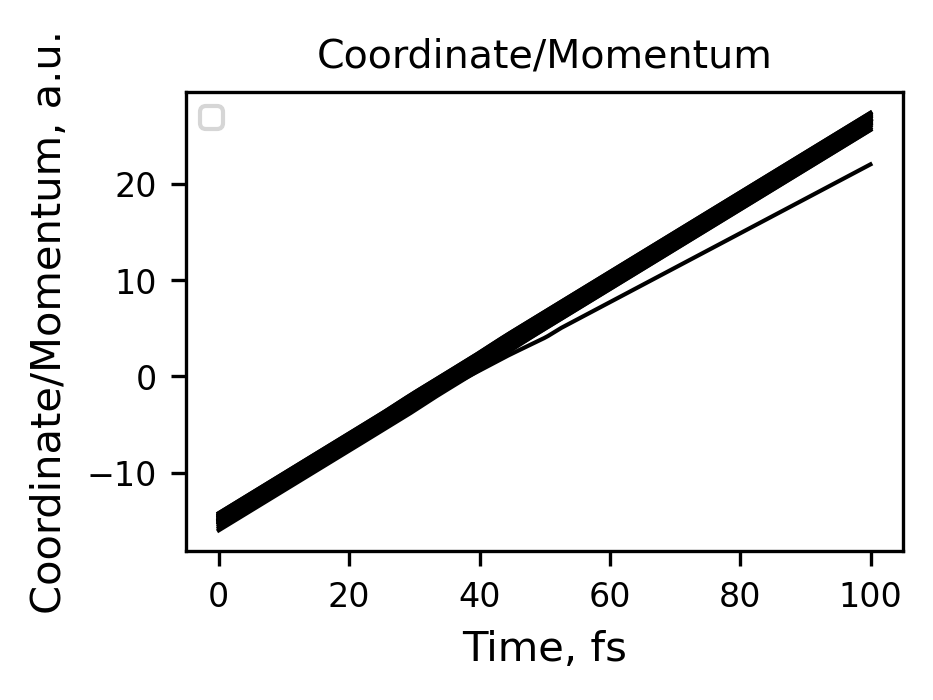

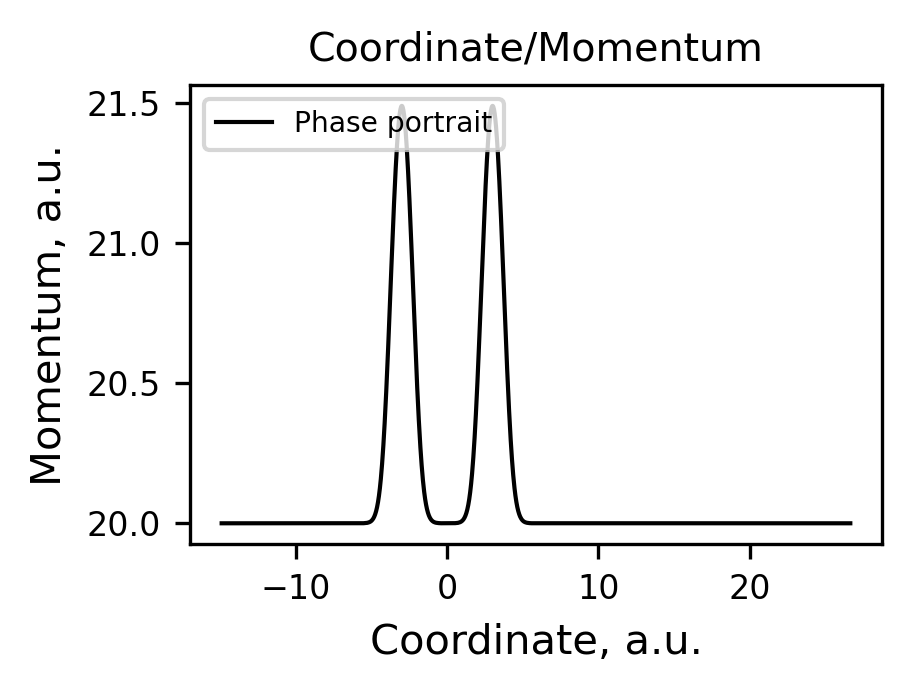

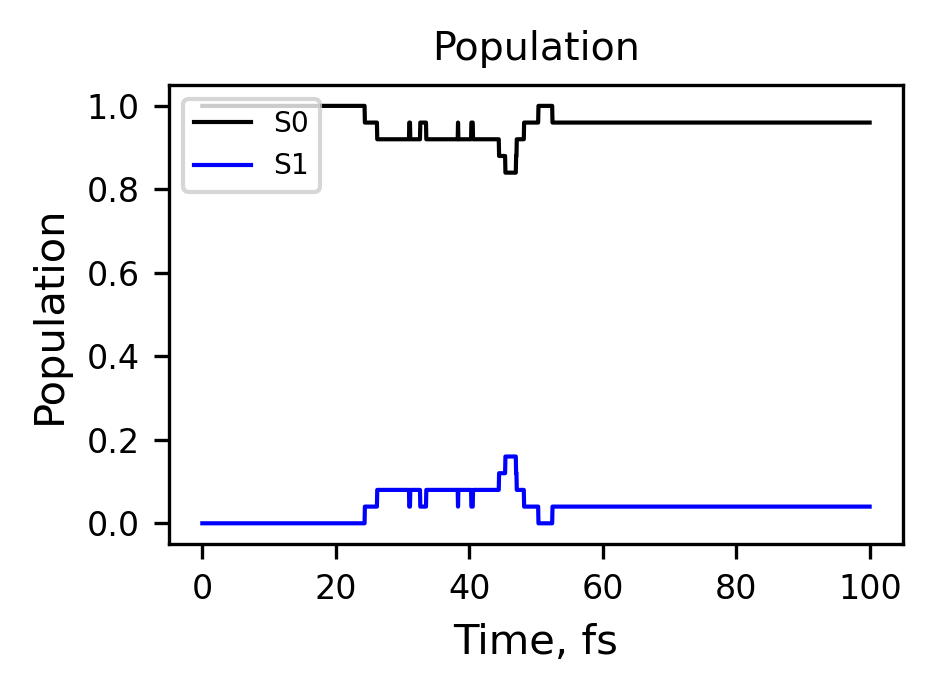

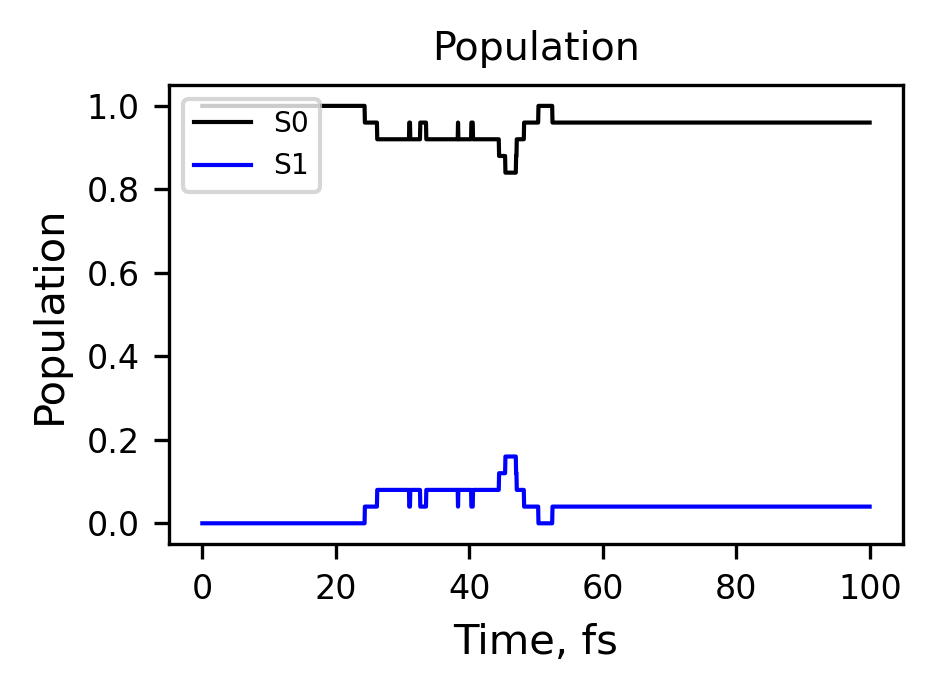

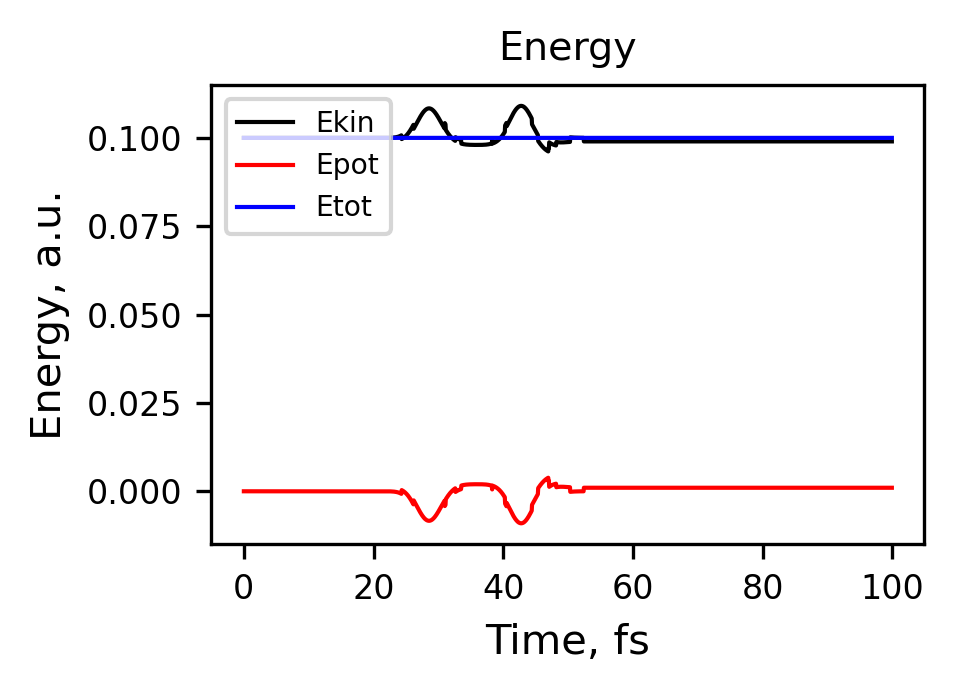

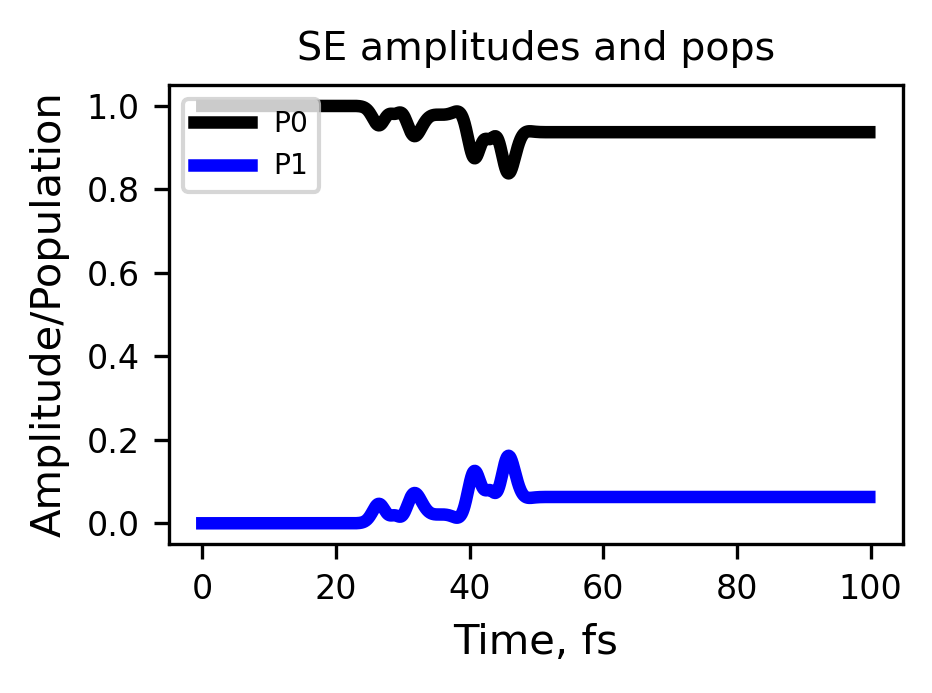

In [21]:
plots("MDL_4_P0_20.0_RECIPE_80", 0, "_FSSH_D_D+_no_decoh", 0)

## 4. Analysis of the scattering <a name="4"></a>
[Back to TOC](#TOC)

The blocks of this section are also implemented in the `analysis.py` script supplied with this tutorial.

### 4.1. Plotting and analysis functions <a name="4.1"></a>
[Back to TOC](#TOC)

The functions' description:

* `get_stats` - this is the main analysis function. It looks at the end of the coordinates for all trajectories (last line of the `q.txt` files) and determines if the particles is transmitted (q > 5) or reflected (q < 5); it also looks at the quantum state of the corresponding trajectory to see if the simulation ends up on the lower or the upper state. The results of this analysis are saved in the corresponding .hdf file that can be used later for plotting

* `scatter_plot` - this function simply plots the re/tr probabilities for all initial conditions (momenta) for a given model and method.

* `plot_models` - plots the scattering probability plots for all models/methods considered. 

<a name="creating_hdf5"></a><a name="reading_hdf5"></a>

In [22]:
def get_stats(prefix, mdls, P0, batches, ntraj, methods):

    nmdls = len(mdls)
    npts = len(P0)
    nstates = 2
    nscatt = 2 # scattering channels
  
    X = np.zeros((nmdls, npts), dtype=float)
    Y = np.zeros((nmdls, npts, nstates, nscatt), dtype=float)
    
    cols = list(range(ntraj))

    for method in methods:

        recipe = recipe_inv_mapping(method)
        rec_name, rec_params = set_recipe(recipe)
            
        for imdl, mdl in enumerate(mdls): 
        
            for ip0, p0 in enumerate(P0):
        
                X[imdl, ip0] = p0
        
                cnt = 0.0
                for batch in batches:
                    #filename = F"{prefix}{mdl}_{int(p0)}/start_s0_BC_FSSH_batch{batch}"
                    filename = F"{prefix}{mdl}_P0_{p0}_RECIPE_{method}/start_s0_{rec_name}_batch{batch}"
                    states = data_read.get_data_from_file2(F"{filename}/states.txt", cols)
                    coords = data_read.get_data_from_file2(F"{filename}/q.txt", cols)                 
        
                    for itraj in range(ntraj):                
        
                        ist = int(states[itraj][-1])
                        q = coords[itraj][-1]
        
                       
                        if q<-5: # reflection on state ist
                            Y[imdl, ip0, ist, 0 ] += 1 
                            cnt += 1 
        
                        elif q>5: # transmission on state ist
                            Y[imdl, ip0, ist, 1 ] += 1 
                            cnt += 1
        
                print(Y, cnt)
                if cnt > 0:
                    Y[imdl, ip0, :, :] = Y[imdl, ip0, :, :] / cnt
        
                    
            #plots(F"model_{mdl}", imdl, X, Y)
        
            with h5py.File(F"model_{mdl}_method_{method}.hdf", "w") as f:
                #g = f.create_group("data")
                f.create_dataset("X", data = X)
                f.create_dataset("Y", data = Y)


                
def scatter_plots(prefix, imdl, X, Y):
    """
    This function produces nice plots of the ground state populations for all calculations
    """

    plt.rc('axes', titlesize=12)      # fontsize of the axes title
    plt.rc('axes', labelsize=12)      # fontsize of the x and y labels
    plt.rc('legend', fontsize=10)     # legend fontsize
    plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
    plt.rc('figure.subplot', left=0.2)
    plt.rc('figure.subplot', right=0.95)
    plt.rc('figure.subplot', bottom=0.13)
    plt.rc('figure.subplot', top=0.88)
   

    figure = plt.figure(num=imdl, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)    

    
    plt.plot(X[imdl, :], Y[imdl, :, 0, 0], color="black", label="reflection on state 0", linewidth=1)
    plt.plot(X[imdl, :], Y[imdl, :, 0, 1], color="blue", label="transmission on state 0", linewidth=1)
    plt.plot(X[imdl, :], Y[imdl, :, 1, 0], color="red", label="reflection on state 1", linewidth=1)
    plt.plot(X[imdl, :], Y[imdl, :, 1, 1], color="green", label="transmission on state 1", linewidth=1)


    
    plt.title("",fontsize=9.5)
    plt.legend(fontsize=6.75, ncol=1, loc='upper left')
    plt.xlabel('Momentum, a.u.',fontsize=10)
    plt.ylabel('Population ',fontsize=10)
    plt.tight_layout()
    plt.savefig(F"{prefix}.png", dpi=300)
    plt.show()                                                                                                            

    
def plot_models(mdls, methods):

    for method in methods:

        for imdl, mdl in enumerate(mdls):
            with h5py.File(F"model_{mdl}_method_{method}.hdf", "r") as f: 
                print( list(f.keys() ) )
                print(f["X"].shape)
                print(f["Y"].shape)
            
                scatter_plots(F"model_{mdl}_method_{method}", imdl, f["X"], f["Y"])
            


### 4.2. Run calculations and plot the results<a name="4.2"></a>
[Back to TOC](#TOC)

Finally, we can run the statistics and plot the results.

**Notes:**
- `P0` should be consistent with what is used in [2.4](#2.4)
- `methods` should be consistent with what is used in [2.4](#2.4) or should be a subset of those 
- `ntraj` should be the same as what is used in [2.3](#2.3)
- `batches` should be a subset of what is used in [2.3](#2.3)


[[[[ 0. 50.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]]] 50.0
[[[[ 0.  1.]
   [ 0.  0.]]

  [[ 0. 49.]
   [ 0.  1.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]]] 50.0
[[[[0.0e+00 1.0e+00]
   [0.0e+00 0.0e+00]]

  [[0.0e+00 9.8e-01]
   [0.0e+00 2.0e-02]]

  [[0.0e+00 4.4e+01]
   [0.0e+00 6.0e+00]]

  [[0.0e+00 0.0e+00]
   [0.0e+00 0.0e+00]]

  [[0.0e+00 0.0e+00]
   [0.0e+00 0.0e+00]]

  [[0.0e+00 0.0e+00]
   [0.0e+00 0.0e+00]]]] 50.0
[[[[0.0e+00 1.0e+00]
   [0.0e+00 0.0e+00]]

  [[0.0e+00 9.8e-01]
   [0.0e+00 2.0e-02]]

  [[0.0e+00 8.8e-01]
   [0.0e+00 1.2e-01]]

  [[0.0e+00 4.6e+01]
   [0.0e+00 4.0e+00]]

  [[0.0e+00 0.0e+00]
   [0.0e+00 0.0e+00]]

  [[0.0e+00 0.0e+00]
   [0.0e+00 0.0e+00]]]] 50.0
[[[[0.0e+00 1.0e+00]
   [0.0e+00 0.0e+00]]

  [[0.0e+00 9.8e-01]
   [0.0e+00 2.0e-02]]

  [[0.0e+00 8.8e-01]
   

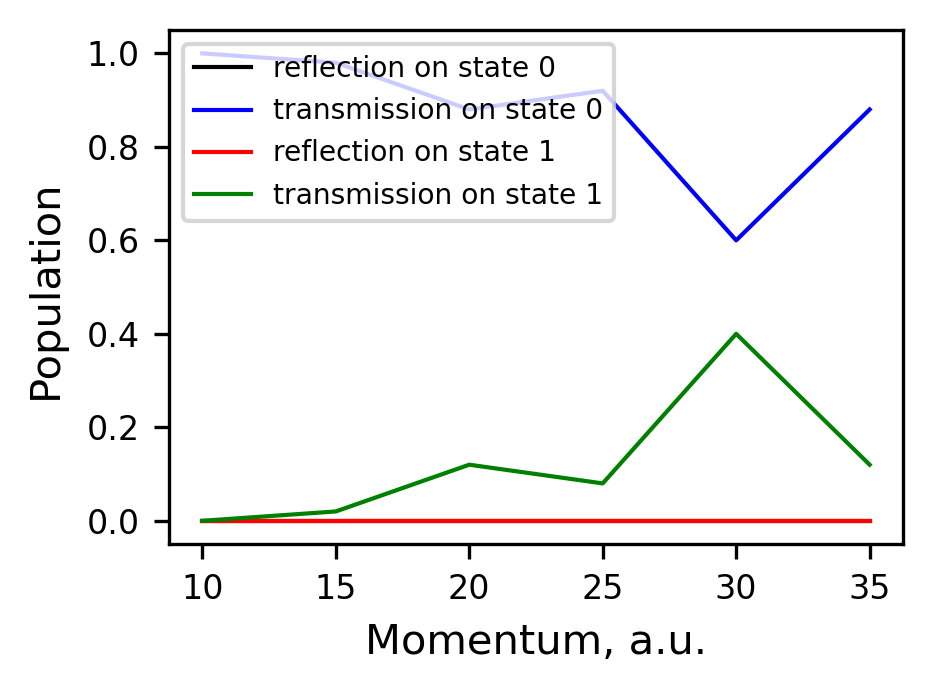

In [25]:
prefix = "MDL_"
mdls = [4]
P0 = np.arange(10.0, 40.0, 5.0)
batches = [0, 1]
ntraj = 25
methods = [80]
    
    
get_stats(prefix, mdls, P0, batches, ntraj, methods)
plot_models(mdls, methods)
